In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import re

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Open Sans']
# rcParams['font.weight'] = 'semibold'

haec_h = (0 / 256.0, 113 / 256.0, 157 / 256.0)
haec_a = (14 / 256.0, 180 / 256.0, 142 / 256.0)
haec_e = (138 / 256.0, 200 / 256.0, 101 / 256.0)
haec_c = (178 / 256.0, 210 / 256.0, 51 / 256.0)

seed_to_plot = 11
max_time = 50
runs = [0,1,2]

name_to_read = '../output/last_output.csv'

In [3]:
FORMAT = re.compile('GeneratedI(\d+)O(\d+)Seed(\d+)')

def change_model_name(old_name):
    match = FORMAT.match(old_name)
    if match:
        return 'Input: {}\nOutput: {}\nSeed: {}'.format(*match.groups())
    return old_name

def normalise_data(data):
    data = data.groupby(['Tool', 'Model', 'RunIndex', 'MetricName']).aggregate({'MetricValue': 'sum'}).reset_index()
    data = data.groupby(['Tool', 'Model', 'MetricName']).mean().reset_index()
    data.loc[:, 'Model'] = data['Model'].apply(change_model_name)
    return data

#    # get the baselines
#    objective = data[np.where(0 == data['numClusters'])][0]['objective']
#    generationTime = data[np.where(0 == data['numClusters'])][0]['generationTime']
#    solvingTime = data[np.where(0 == data['numClusters'])][0]['solvingTime']

#    # remove the unclustered measurement
#    data = data[np.where(data['numClusters'] != 0)]

#    data['objective'] = objective / data['objective']
#    data['objective'][np.isinf(data['objective'])] = 0

#    return objective, generationTime, solvingTime, data

In [4]:
def read_measurements(file_name=None):
    if file_name is None:
        file_name = name_to_read
    data = pd.read_csv(file_name, delimiter=';')
                       #, skip_header=0,
                       #  names=('Tool', 'Model', 'RunIndex', 'PhaseName', 'MetricName', 'MetricValue'))
                         #dtype=(string,str,int,str,str,float))

    # Normalize data
    data = normalise_data(data)

    # Split time and memory data
    time_data = data[data['MetricName'] == 'Time'].copy()
    memory_data = data[data['MetricName'] == 'Memory'].copy()
    time_data.loc[:, 'MetricValue'] = data['MetricValue'] / 10e6
    memory_data.loc[:, 'MetricValue'] = data['MetricValue'] / 2**20

#    data['value'] = data['MetricValue'] / 10e6
    return (time_data, memory_data)

In [5]:
my_dpi = 300
# plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# f, axes = plt.subplots(2, 3, sharey=False,figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# plt.subplots_adjust(left=.04,right=.96,bottom=.15, top=.96, wspace=.4, hspace=.2)
# plt.tight_layout()

Original CSV header was: 

run|seed|numClusters|isValid|objective|clusteringTime|generationTime|solvingTime
-|-|-|-|-|-|-|-
0|11|0|true|1104501.5899999999|0|2451|20838

And new header is:

Tool|Model|RunIndex|PhaseName|MetricName|MetricValue
-|-|-|-|-|-
EMFSolutionATLGraph|Test.ttmodel|0|Initialization|Time|270028458


In [6]:
data, _ = read_measurements()
normalise_data(data)
pd.DataFrame(data).head()

,Tool,Model,MetricName,RunIndex,MetricValue
1,EMFSolutionATL,Input: 4\nOutput: 2\nSeed: 42,Time,0,133.777700
3,EMFSolutionATL,Input: 8\nOutput: 2\nSeed: 68,Time,0,5775.728055
5,EMFSolutionATL,Input: 8\nOutput: 4\nSeed: 68,Time,0,7481.447651
7,EMFSolutionATL,Test.ttmodel,Time,0,119.489966
9,EMFSolutionATLGraph,Input: 4\nOutput: 2\nSeed: 42,Time,0,117.359443


In [7]:
d1 = data.groupby(['Tool', 'Model', 'RunIndex', 'MetricName']).aggregate({'MetricValue': 'sum'}).reset_index()
d1

,Tool,Model,RunIndex,MetricName,MetricValue
0,EMFSolutionATL,Input: 4\nOutput: 2\nSeed: 42,0,Time,133.777700
1,EMFSolutionATL,Input: 8\nOutput: 2\nSeed: 68,0,Time,5775.728055
2,EMFSolutionATL,Input: 8\nOutput: 4\nSeed: 68,0,Time,7481.447651
3,EMFSolutionATL,Test.ttmodel,0,Time,119.489966
4,EMFSolutionATLGraph,Input: 4\nOutput: 2\nSeed: 42,0,Time,117.359443
5,EMFSolutionATLGraph,Input: 8\nOutput: 2\nSeed: 68,0,Time,5772.619875
6,EMFSolutionATLGraph,Input: 8\nOutput: 4\nSeed: 68,0,Time,7179.407800
7,EMFSolutionATLGraph,Test.ttmodel,0,Time,100.434793


In [8]:
d2 = d1.groupby(['Tool', 'Model', 'MetricName']).mean().reset_index()
d2

,Tool,Model,MetricName,RunIndex,MetricValue
0,EMFSolutionATL,Input: 4\nOutput: 2\nSeed: 42,Time,0,133.777700
1,EMFSolutionATL,Input: 8\nOutput: 2\nSeed: 68,Time,0,5775.728055
2,EMFSolutionATL,Input: 8\nOutput: 4\nSeed: 68,Time,0,7481.447651
3,EMFSolutionATL,Test.ttmodel,Time,0,119.489966
4,EMFSolutionATLGraph,Input: 4\nOutput: 2\nSeed: 42,Time,0,117.359443
5,EMFSolutionATLGraph,Input: 8\nOutput: 2\nSeed: 68,Time,0,5772.619875
6,EMFSolutionATLGraph,Input: 8\nOutput: 4\nSeed: 68,Time,0,7179.407800
7,EMFSolutionATLGraph,Test.ttmodel,Time,0,100.434793


In [9]:
good_colors = ['#000000','#e69f00','#56b4e9','#009e73','#f0e442','#0072b2','#d55e00','#cc79a7']
good_shapes = ['o', 's', 'v', '^', 'x']
good_dashes = ['-', '--', ':', '-.']

info = {
    'EMFSolutionATL':        (good_colors[0], good_shapes[0], good_dashes[0], 'ATL'),
    'EMFSolutionATLGraph':   (good_colors[1], good_shapes[1], good_dashes[0], 'ATL (Graph)'),
    'RelationalRAGSolution': (good_colors[2], good_shapes[2], good_dashes[0], 'RelRAG')
}

In [10]:
def draw_part(data_to_draw, name, axis_title, legend_position):
    fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
    ax1 = fig.add_subplot(111)

    ax1.set_xlabel('Model instance',weight='semibold',name='Open Sans')
    ax1.set_ylabel(axis_title, weight='semibold',name='Open Sans')
    #ax1.set_xticks(range(320,6401,640), minor=True)
    #ax1.set_xticks(range(640,6401,640), minor=False)

    #ax2 = ax1.twinx()
    #ax2.set_ylabel('quality', color=haec_h,weight='semibold',name='Open Sans')

    #objective, generationTime, totalTime, data = normalise_data(data, seed_to_plot)
    #print(data)

    #ax1.plot(data['Model'], [1] * len(data), color=haec_h, linestyle='dashed', linewidth=1, alpha=0.5,label='memory consumption')
    #ax2.plot(data['Model'], [totalTime] * len(data), color=haec_a, linestyle='dashed', linewidth=1, alpha=0.5,label='total run time')
    #ax2.plot(data['Model'], [generationTime] * len(data), color=haec_e, linestyle='dashed', linewidth=1, alpha=0.5,label='unclustered generation time')
    # first = True
    #for run in runs:
    #    data_for_tool = data[np.where(data['run'] == run)]
    #    if first:
    #        ax1.plot(data_for_tool['Model'], data_for_tool['objective'], color=haec_h,label='solution quality',marker='o')
    #        ax2.plot(data_for_tool['Model'], data_for_tool['clusteringTime'], color=haec_c, label='clustering time',marker='o', mfc='w')
    #        ax2.plot(data_for_tool['Model'], data_for_tool['generationTime'], color=haec_e, label='generation time',marker='o', mfc='w')
    #        ax2.plot(data_for_tool['Model'], data_for_tool['solvingTime'], color=haec_a,label='total solving time',marker='o', mfc='w')
    #        first = False
    #    else:
    for tool in np.unique(data_to_draw['Tool']):
        data_for_tool = data_to_draw[data_to_draw['Tool'] == tool]
        color, shape, dash, nice_name = info[tool]
    #    ax1.plot(data_for_tool['Model'], data_for_tool['objective'], color=haec_h,marker='o')
        ax1.plot(data_for_tool['Model'], data_for_tool['MetricValue'], color=color,
                 label=nice_name, marker=shape, mfc=color, linestyle=dash)
    #    ax2.plot(data_for_tool['Model'], data_for_tool['generationTime'], color=haec_e, marker='o', mfc='w')
    #    ax2.plot(data_for_tool['Model'], data_for_tool['solvingTime'], color=haec_a,marker='o', mfc='w')

    ax1.legend(loc=legend_position)
    #ax2.legend(loc='upper right')

    #ax1.set_ylim(0, 1.19)
    ax1.set_ylim(0, 1.19 * data_to_draw['MetricValue'].max())

    fig.savefig('run_time.pdf', format="pdf")
    fig.savefig('run_time.png', format="png")

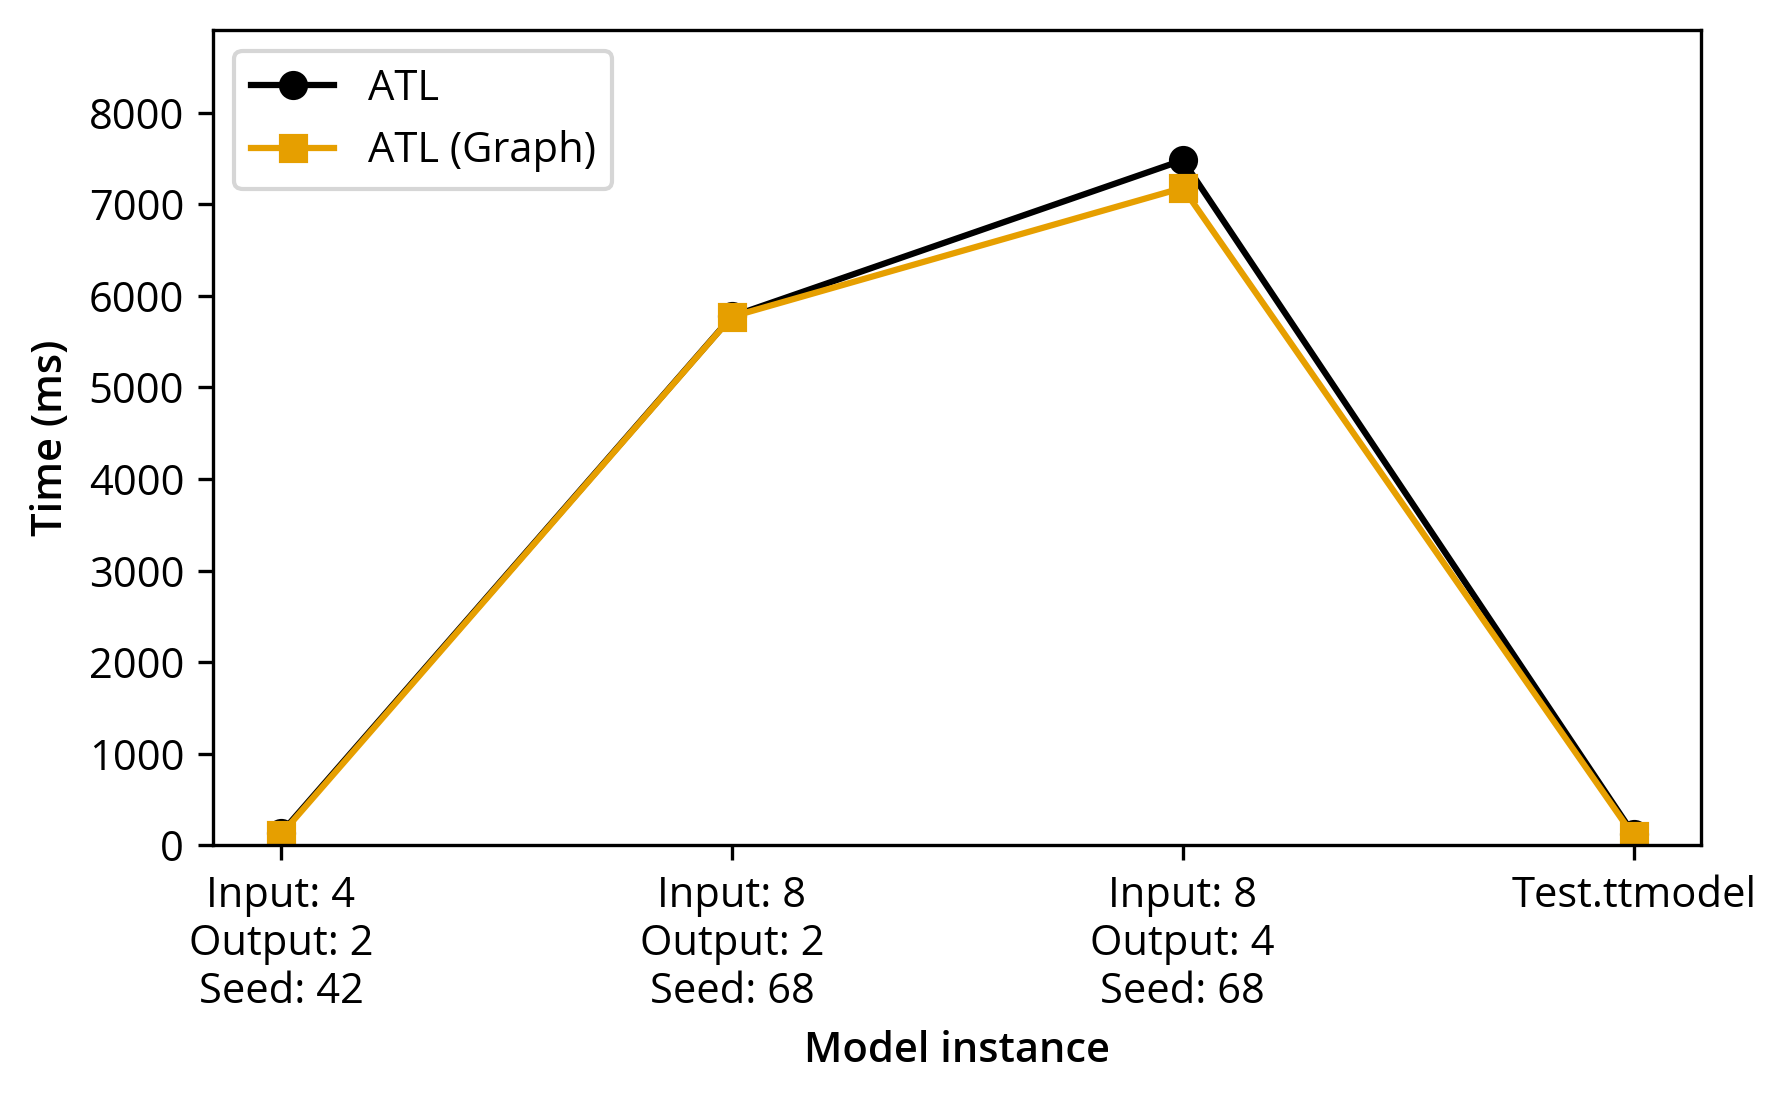

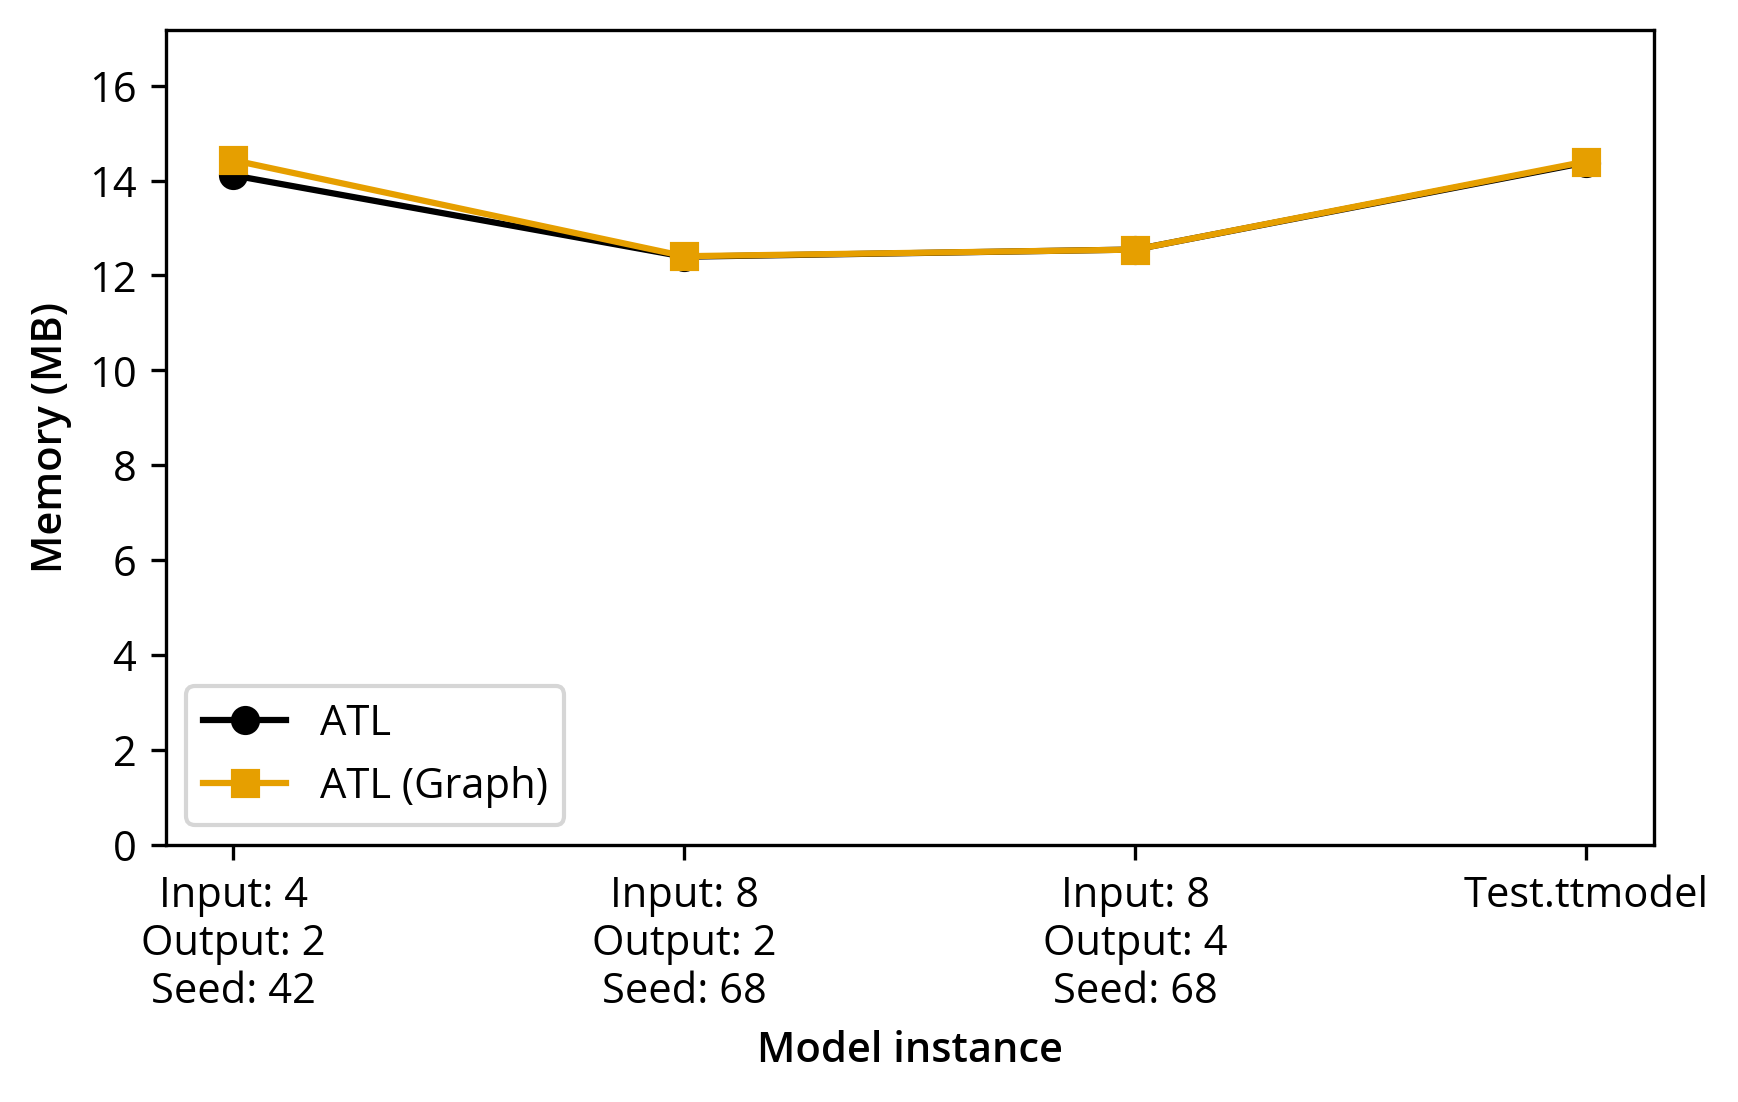

In [11]:
time_data, memory_data = read_measurements()
draw_part(time_data, name='run_time', axis_title='Time (ms)', legend_position='upper left')
draw_part(memory_data, name='memory', axis_title='Memory (MB)', legend_position='lower left')